# All the Library imports

In [1]:
import mimetypes
from pathlib import Path
import os
import sys
import random
import shutil
from tempfile import TemporaryDirectory
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import torch as tc
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import albumentations as A
import torch.nn as nn
from tqdm.notebook import trange, tqdm

# Data Aquisition

### Clone the github repo to get all the data we have collected

In [2]:
dataDir = TemporaryDirectory(dir='/content/sample_data', prefix='github_')
!git clone https://github.com/waruna-wickramasingha/landmark-detection.git $dataDir.name
# !git -C $dataDir.name/landmarks checkout feature/datarestructure

Cloning into '/content/sample_data/github_cunhsq6n'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1960 (delta 13), reused 51 (delta 13), pack-reused 1907
Receiving objects: 100% (1960/1960), 1.95 GiB | 17.53 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (1682/1682), done.


In [3]:
def getFilesList(path: str, desiredExtensionList, recursion=False):
  fileList = []
  path = Path(path)
  if recursion == False:
    for x in path.iterdir():
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  else:
    for x in path.glob('**/*'):
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  return fileList

In [4]:
def getImageNameToClassMap(annotationsDir:str):
  aggrImageNameToClassMap = dict()
  annotationsDir = Path(annotationsDir)
  try:
    for x in annotationsDir.iterdir():
      if x.suffix.lower() == ".json":
        with open(x, 'r') as f:
          annotationDict = json.load(f)
          annList = list(map(dict, annotationDict.values()))
          image_name_to_class_map = { it['filename'] : it['regions'][0]['region_attributes']['class'].lower() for it in annList }
          aggrImageNameToClassMap.update(image_name_to_class_map)
  except:
    raise Exception("Failed to aggregate annotated json files")
  finally:
    print("Annotation files aggragated successfully!")
  return aggrImageNameToClassMap

In [5]:
im_name_to_class = getImageNameToClassMap(dataDir.name + '/annotations')
len(im_name_to_class)

Annotation files aggragated successfully!


1655

In [6]:
im_name_to_class

{'CACF5197.JPG': 'bournemouth and poole college',
 'IMG_7839.JPG': 'bournemouth and poole college',
 'IMG_7841.JPG': 'bournemouth and poole college',
 'IMG_7844.JPG': 'bournemouth and poole college',
 'IMG_7850.JPG': 'bournemouth and poole college',
 'IMG_7853.JPG': 'bournemouth and poole college',
 'IMG_7858.JPG': 'bournemouth and poole college',
 'IMG_7859.JPG': 'bournemouth and poole college',
 'IMG_7861.JPG': 'bournemouth and poole college',
 'IMG_7863.JPG': 'bournemouth and poole college',
 'IMG_7867.JPG': 'bournemouth and poole college',
 'IMG_7870.JPG': 'bournemouth and poole college',
 'IMG_7880.JPG': 'bournemouth and poole college',
 'IMG_7881.JPG': 'bournemouth and poole college',
 'IMG_7882.JPG': 'bournemouth and poole college',
 'IMG_7888.JPG': 'bournemouth and poole college',
 'IMG_7901.JPG': 'bournemouth and poole college',
 'IMG_7902.JPG': 'bournemouth and poole college',
 'IMG_7536.JPG': 'careers center',
 'IMG_7537.JPG': 'careers center',
 'IMG_7539.JPG': 'careers cent

In [7]:
all_classes = set(im_name_to_class.values())
all_classes

{'aldi wallisdown',
 'aniba',
 'art studios',
 'arts bar',
 'arts bu library',
 'asda',
 'ashley automotive',
 'auds',
 'aush',
 'auss',
 'autg',
 'baboo ji',
 'bailey point',
 'beales',
 'bellaton house',
 'block a and block b arts university',
 'bobbys',
 'bournemouth and poole college',
 'bournemouth gateway building',
 'bu executive business centre',
 'bu international college',
 'bu lansdowne',
 'bu student house',
 'buch',
 'burley court hotel',
 'buta',
 'buth',
 'careers center',
 'cbd flower shop',
 'church',
 'coop store',
 'court royal',
 'courtleigh manor',
 'cranborne house',
 'design and engineering innovation center',
 'dorchester house',
 'dorset house',
 'east cliff urc church',
 'enterprise house',
 'fairways care home',
 'fern arrow roundabout',
 'fusion building',
 'gorscliff court',
 'hilton',
 'home park',
 'hot rocks',
 'iq building',
 'jakey house',
 'kimmeridge house',
 'lester aldridge',
 'lidl bournemouth',
 'lush',
 'mccarthy stone head office',
 'minton lod

In [8]:
len(all_classes)

100

In [10]:
for k,v in im_name_to_class.items():
  if v == '':
    print(k)

In [11]:
beforeAugImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='BeforeAugmentation_')
testImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Test_')

## Re-arrange data into train and test sets using 75% trainig split 

In [12]:
image_extensions = [k for k,v in mimetypes.types_map.items() if 'image/' in v]
random.seed(13)

def reArrangeImagesIntoTrainTest(lm_dir:str, trainDir:str, testDir:str, trainSplit=0.75):
  """
  This method would split the original list of images provided in imagesList 
  by moving them into trainDir and testDir keeping the original file name.
  """
  global image_extensions
  imagesList = getFilesList(lm_dir, image_extensions)
  imagesList = np.array(imagesList)
  randSelections = np.random.permutation(len(imagesList))

  trainTestCutPoint = int(len(imagesList)*trainSplit)
  trainImages = imagesList[randSelections[:trainTestCutPoint]]
  testImages = imagesList[randSelections[trainTestCutPoint:]]

  lm_dir_name = lm_dir.split(os.sep)[-1]

  try:
    #Re-arrange train images
    lm_train_dir = TemporaryDirectory(dir=trainDir, prefix=lm_dir_name)
    print("Creating Train directory={}".format(lm_train_dir.name))
    for p in trainImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_train_dir.name + os.sep + imageName
      shutil.move(p, newPath)

    #Re-arrange test images
    lm_test_dir = TemporaryDirectory(dir=testDir, prefix=lm_dir_name)
    print("Creating Test directory={}".format(lm_test_dir.name))
    for p in testImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_test_dir.name + os.sep + imageName
      shutil.move(p, newPath)
  except:
    raise Exception("Failed to move images into train={} and test={} directories".
                    format(lm_train_dir.name, lm_test_dir.name))
  return (lm_train_dir, lm_test_dir)

In [13]:
landmarks_dir = Path(dataDir.name+os.sep+'landmarks')
tempdirs = []
for lm in landmarks_dir.glob('**/'):
  if lm == landmarks_dir:
    continue
  print("\n Original direcotry={}".format(lm))
  tempdirs.append(reArrangeImagesIntoTrainTest(str(lm), beforeAugImagesRoot.name, testImagesRoot.name, 0.75))


 Original direcotry=/content/sample_data/github_cunhsq6n/landmarks/Slug
Creating Train directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Slugeixvw481
Creating Test directory=/content/sample_data/Test_i20qhx90/Slug1gvj_yo5

 Original direcotry=/content/sample_data/github_cunhsq6n/landmarks/Beales
Creating Train directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Bealesdake9dtp
Creating Test directory=/content/sample_data/Test_i20qhx90/Bealesdt19cyfw

 Original direcotry=/content/sample_data/github_cunhsq6n/landmarks/Bournemouth Gateway Building
Creating Train directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Bournemouth Gateway Building2yid12xf
Creating Test directory=/content/sample_data/Test_i20qhx90/Bournemouth Gateway Buildingfow1fu9c

 Original direcotry=/content/sample_data/github_cunhsq6n/landmarks/BU Tolpuddle Annex-1
Creating Train directory=/content/sample_data/BeforeAugmentation_h7g2hby6/BU Tolpuddle Annex-10qfctvu3
Creating Test directory=/content/s

In [15]:
image_extensions

['.bmp',
 '.gif',
 '.ief',
 '.jpg',
 '.jpe',
 '.jpeg',
 '.heic',
 '.heif',
 '.png',
 '.svg',
 '.tiff',
 '.tif',
 '.ico',
 '.ras',
 '.pnm',
 '.pbm',
 '.pgm',
 '.ppm',
 '.rgb',
 '.xbm',
 '.xpm',
 '.xwd']

In [14]:
getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_15.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_12.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_2.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_10.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_20.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_6.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_8.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_1.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_13.jpg'),
 PosixPath('/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a/Hilton_1 of_16.jpg'),
 PosixPath('/content/sam

In [17]:
getFilesList(testImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/Test_i20qhx90/Gorscliff Court2xjng6hb/Gorscliff Court_1.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/Gorscliff Court2xjng6hb/Gorscliff Court_2.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/The Gallery Arts Universityit14nb1x/The Gallery Arts University_12.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/The Gallery Arts Universityit14nb1x/The Gallery Arts University_17.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/The Gallery Arts Universityit14nb1x/The Gallery Arts University_6.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/The Gallery Arts Universityit14nb1x/The Gallery Arts University_10.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/The Gallery Arts Universityit14nb1x/The Gallery Arts University_11.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/East cliff urc churchvt7tqvxo/IMG_8009.JPG'),
 PosixPath('/content/sample_data/Test_i20qhx90/East cliff urc churchvt7tqvxo/IMG_8003.JPG'),
 PosixPath('/conte

## Define class to integer and integer to class conversion data structures to map string class names to numbers and vice-versa

In [20]:
all_classes

{'aldi wallisdown',
 'aniba',
 'art studios',
 'arts bar',
 'arts bu library',
 'asda',
 'ashley automotive',
 'auds',
 'aush',
 'auss',
 'autg',
 'baboo ji',
 'bailey point',
 'beales',
 'bellaton house',
 'block a and block b arts university',
 'bobbys',
 'bournemouth and poole college',
 'bournemouth gateway building',
 'bu executive business centre',
 'bu international college',
 'bu lansdowne',
 'bu student house',
 'buch',
 'burley court hotel',
 'buta',
 'buth',
 'careers center',
 'cbd flower shop',
 'church',
 'coop store',
 'court royal',
 'courtleigh manor',
 'cranborne house',
 'design and engineering innovation center',
 'dorchester house',
 'dorset house',
 'east cliff urc church',
 'enterprise house',
 'fairways care home',
 'fern arrow roundabout',
 'fusion building',
 'gorscliff court',
 'hilton',
 'home park',
 'hot rocks',
 'iq building',
 'jakey house',
 'kimmeridge house',
 'lester aldridge',
 'lidl bournemouth',
 'lush',
 'mccarthy stone head office',
 'minton lod

In [21]:
i2c = list(all_classes)
c2i = {v:i for i,v in enumerate(i2c)}

In [24]:
i2c

['ocean 80',
 'hilton',
 'fairways care home',
 'mccarthy stone head office',
 'talbot bus stop',
 'courtleigh manor',
 'art studios',
 'obscura',
 'skyline accomodation',
 'fusion building',
 'buth',
 'auds',
 'poole house',
 'baboo ji',
 'bu international college',
 'east cliff urc church',
 'iq building',
 'odeon',
 'timebomb tattoo studio',
 'fern arrow roundabout',
 'buta',
 'burley court hotel',
 'bu lansdowne',
 'the gallery arts university',
 'oneils bournemouth hidden gem',
 'arts bu library',
 'nation-wide',
 'careers center',
 'st john boscombe',
 'aniba',
 'park central',
 'richmond-gate',
 'slug',
 'cbd flower shop',
 'sports bu',
 'wiggle',
 'beales',
 'home park',
 'the artisans',
 'old fire station',
 'autg',
 'bobbys',
 'student center',
 'kimmeridge house',
 'oxford point',
 'arts bar',
 'lidl bournemouth',
 'viztality',
 'court royal',
 'the kings arms bar',
 'sir micheal cobhem library',
 'talbot uni roundabout',
 'auss',
 'design and engineering innovation center',

In [25]:
c2i

{'ocean 80': 0,
 'hilton': 1,
 'fairways care home': 2,
 'mccarthy stone head office': 3,
 'talbot bus stop': 4,
 'courtleigh manor': 5,
 'art studios': 6,
 'obscura': 7,
 'skyline accomodation': 8,
 'fusion building': 9,
 'buth': 10,
 'auds': 11,
 'poole house': 12,
 'baboo ji': 13,
 'bu international college': 14,
 'east cliff urc church': 15,
 'iq building': 16,
 'odeon': 17,
 'timebomb tattoo studio': 18,
 'fern arrow roundabout': 19,
 'buta': 20,
 'burley court hotel': 21,
 'bu lansdowne': 22,
 'the gallery arts university': 23,
 'oneils bournemouth hidden gem': 24,
 'arts bu library': 25,
 'nation-wide': 26,
 'careers center': 27,
 'st john boscombe': 28,
 'aniba': 29,
 'park central': 30,
 'richmond-gate': 31,
 'slug': 32,
 'cbd flower shop': 33,
 'sports bu': 34,
 'wiggle': 35,
 'beales': 36,
 'home park': 37,
 'the artisans': 38,
 'old fire station': 39,
 'autg': 40,
 'bobbys': 41,
 'student center': 42,
 'kimmeridge house': 43,
 'oxford point': 44,
 'arts bar': 45,
 'lidl bou

Let's check whether we can find a class for all the images in the data set with the original images before augmentation.

In [27]:
for f in getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  orig_im_name = str(image_filepath).split(os.sep)[-1]
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

Check whether all the images in the test data set has a class associated

In [28]:
for f in getFilesList(testImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  im_name = str(image_filepath).split(os.sep)[-1]
  orig_im_name = im_name
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

# Data Augmentation

In [30]:
def doAugmentation(inputDir: str, outputDirRoot: str, augmentationPipeline, numberOfTargetSamples):
  """
  This function is to perform image augmentations for the images present at the 'inputDir' 
  into the root location as specified at 'outputDirRoot' using the function 'augmentationPipeline' 
  which takes in an image and output an augmented image. The new directory will be created with the same prefix
  as the input directory and it will contain all the original images plus a number of augmented images 
  such that 'numberOfTargetSamples' is reached
  """
  inputDirPath = Path(inputDir)
  originalImagePaths = []

  global image_extensions
  for x in inputDirPath.iterdir():
      if x.suffix.lower() in image_extensions:
          originalImagePaths.append(x)

  origLMDir = inputDir.split(os.sep)[-1]

  try:
      augLMDir = TemporaryDirectory(dir=outputDirRoot, prefix="{}_Aug_".format(origLMDir))
  except:
      raise Exception("Error creating temp dir for augmentations")

  print("Original Directory={}, Augmented Directory={}".format(inputDir, augLMDir.name))

  for im in originalImagePaths:
      imageName = str(im).split(os.sep)[-1]
      outputImagePath = augLMDir.name + os.sep + imageName
      
      try:
          shutil.copy(im, outputImagePath)
      except:
          raise Exception("Failed to copy original file {} to {}".format(im, outputImagePath))

  augCandidates = random.choices(originalImagePaths, k=(numberOfTargetSamples-len(originalImagePaths)))
  aug_ind = 0

  for impath in augCandidates:
      im = cv2.imread(str(impath))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

      augmentedImage = augmentationPipeline(im)
      imageName, imageExt = str(impath).split(os.sep)[-1].split('.')
      outputImagePath = augLMDir.name + os.sep + 'aug#' + str(aug_ind) + '_' + imageName + '.' + imageExt
      aug_ind += 1
      try:
          cv2.imwrite(outputImagePath, augmentedImage)
      except:
          raise Exception("Failed to save augmented image to {}".format(outputImagePath))
      
  return augLMDir

### Define pipelines for data augmentation

In [31]:
transform = A.Compose(
        [A.RandomRotate90(),
        A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.4, p=0.7),
        # A.CLAHE(p=0.7),
        A.HorizontalFlip(p=0.7),
        # A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),
        A.Blur(blur_limit=3)])

def augmentationPipeline(image):
  return transform(image=image)['image']

In [32]:
augmentationDirRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Augmentations')
augmentationDirRoot.name

'/content/sample_data/Augmentationsa331ae5j'

In [ ]:
%%time

# todo ....

original_dir_before_aug = Path(beforeAugImagesRoot.name)
augmented_dirs = []
augmentation_ind = 0
for lm in original_dir_before_aug.glob('**/'):
  if lm == original_dir_before_aug:
    continue
  augmentation_ind += 1

  if augmentation_ind <25:
    #noman
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, noman_augmentationPipeline, 50))
  elif augmentation_ind> 25 and augmentation_ind < 50:
    #vishal
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, vishal_augmentationPipeline, 50))
  elif augmentation_ind> 51 and augmentation_ind < 75:
    #waruna
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, waruna_augmentationPipeline, 50))
  else:
    #ayo
    # augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, ayo_augmentationPipeline, 50))


In [33]:
%%time
original_dir_before_aug = Path(beforeAugImagesRoot.name)
augmented_dirs = []
for lm in original_dir_before_aug.glob('**/'):
  if lm == original_dir_before_aug:
    continue
  augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, augmentationPipeline, 50))

Original Directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Hiltonhad3vg6a, Augmented Directory=/content/sample_data/Augmentationsa331ae5j/Hiltonhad3vg6a_Aug_6x5z6yx8
Original Directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Nation-Wides5zg41tn, Augmented Directory=/content/sample_data/Augmentationsa331ae5j/Nation-Wides5zg41tn_Aug_loq6znkc
Original Directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Enterprise Houser9so6tup, Augmented Directory=/content/sample_data/Augmentationsa331ae5j/Enterprise Houser9so6tup_Aug_o1atjcht
Original Directory=/content/sample_data/BeforeAugmentation_h7g2hby6/Ashley Automotivevr0un0cb, Augmented Directory=/content/sample_data/Augmentationsa331ae5j/Ashley Automotivevr0un0cb_Aug_xqy2o6se
Original Directory=/content/sample_data/BeforeAugmentation_h7g2hby6/bournemouth and poole college60zd1utj, Augmented Directory=/content/sample_data/Augmentationsa331ae5j/bournemouth and poole college60zd1utj_Aug_kpvnyve5
Original Directory=/content

# Define pytorch Data Sets and Data Loaders

In [34]:
class LandmarkDataSet(Dataset):
  def __init__(self, imPathList, im2cl, c2i, transform):
    self.x = imPathList
    self.im2cl = im2cl
    self.c2i = c2i
    self.transform = transform

  def __len__(self): 
    return len(self.x)
    
  def __getitem__(self, ix): 
    image_filepath = str(self.x[ix])
    image = Image.open(image_filepath)
    
    im_name = str(image_filepath).split(os.sep)[-1]
    if 'aug#' in image_filepath:
      orig_im_name = im_name[im_name.find('_')+1:]
    else:
      orig_im_name = im_name

    cls = self.im2cl[orig_im_name]
    label = self.c2i[cls]
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

In [35]:
train_image_paths_list = getFilesList(augmentationDirRoot.name, image_extensions, recursion=True)
test_image_paths_list = getFilesList(testImagesRoot.name, image_extensions, recursion=True)

In [36]:
im_name_to_class

{'CACF5197.JPG': 'bournemouth and poole college',
 'IMG_7839.JPG': 'bournemouth and poole college',
 'IMG_7841.JPG': 'bournemouth and poole college',
 'IMG_7844.JPG': 'bournemouth and poole college',
 'IMG_7850.JPG': 'bournemouth and poole college',
 'IMG_7853.JPG': 'bournemouth and poole college',
 'IMG_7858.JPG': 'bournemouth and poole college',
 'IMG_7859.JPG': 'bournemouth and poole college',
 'IMG_7861.JPG': 'bournemouth and poole college',
 'IMG_7863.JPG': 'bournemouth and poole college',
 'IMG_7867.JPG': 'bournemouth and poole college',
 'IMG_7870.JPG': 'bournemouth and poole college',
 'IMG_7880.JPG': 'bournemouth and poole college',
 'IMG_7881.JPG': 'bournemouth and poole college',
 'IMG_7882.JPG': 'bournemouth and poole college',
 'IMG_7888.JPG': 'bournemouth and poole college',
 'IMG_7901.JPG': 'bournemouth and poole college',
 'IMG_7902.JPG': 'bournemouth and poole college',
 'IMG_7536.JPG': 'careers center',
 'IMG_7537.JPG': 'careers center',
 'IMG_7539.JPG': 'careers cent

### Data Normalization 

In [37]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
    ])

train_ds  = LandmarkDataSet(train_image_paths_list, im_name_to_class, c2i, transf)
test_ds  = LandmarkDataSet(test_image_paths_list, im_name_to_class, c2i, transf)

len(train_ds), len(test_ds)

(5000, 448)

### Utility functions to fit the models and transfer-learn

In [38]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean() 

def one_epoch(net, loss, dl, opt=None, metric=None):   
  if opt: net.train()  # only affects some layers
  else:   net.eval()

  L, M = [], []
  for xb, yb in tqdm(iter(dl), leave=False):
    xb, yb = xb.cuda(), yb.cuda()
    if opt:
      y_ = net(xb)
      l = loss(y_, yb)
      opt.zero_grad()
      l.backward()
      opt.step()
    else:
      with tc.no_grad():
        y_ = net(xb)
        l = loss(y_, yb)
    L.append(l.detach().cpu().numpy())
    if metric: 
      M.append(metric(y_, yb).cpu().numpy())
          
  return L, M


def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):
  opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  Ltr_hist, Lval_hist = [], []
  for epoch in trange(epochs):
    Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
    Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)
    Ltr_hist.append(np.mean(Ltr))
    Lval_hist.append(np.mean(Lval))
    print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
      
  # plot the losses     
  if plot:
    _,ax = plt.subplots(1,1,figsize=(16,4))
    ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
    ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
    ax.grid('on')
    ax.set_xlim(left=1, right=len(Ltr_hist))
    ax.legend(['training loss', 'validation loss']);
      
  return Ltr_hist, Lval_hist

def freeze(md, fr=True):
  ch = list(md.children())
  for c in ch: freeze(c, fr)
  if not ch and not isinstance(md, tc.nn.modules.batchnorm.BatchNorm2d):  # not freezing the BatchNorm layers!
    for p in md.parameters():
      p.requires_grad = not fr

def freeze_to(md, ix=-1, fr=True):
  ch_all = list(md.children())
  for ch in ch_all[:ix]:
    freeze(ch, fr)

In [46]:
from torchvision.models import list_models

In [47]:
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [48]:
temp = models.resnet18(pretrained=True)
temp

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 355MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
temp.fc

Linear(in_features=512, out_features=1000, bias=True)

# Transfer-learning Resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0	training loss: 2.4330	validation loss: 0.6103	validation accuracy: 0.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1	training loss: 0.6721	validation loss: 0.3253	validation accuracy: 0.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2	training loss: 0.4707	validation loss: 0.2931	validation accuracy: 0.94


([2.432987, 0.6721023, 0.47072393], [0.61025345, 0.3252588, 0.29305324])

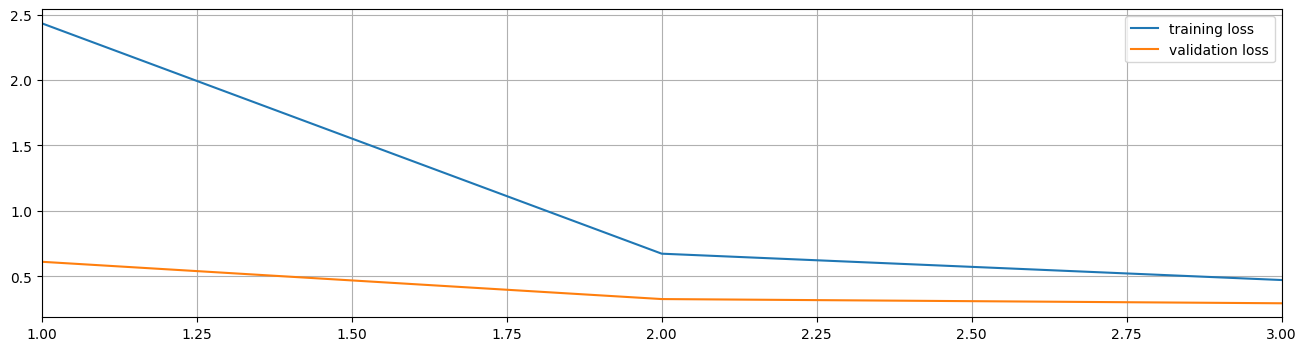

In [ ]:
%%time
bs = 32
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, num_of_classes)
freeze_to(resnet18, -1, True)

resnet18 = resnet18.cuda()

fit(resnet18, tr_dl, val_dl, epochs=3)

# Model by Noman

In [58]:
resnet50 = models.resnet50(pretrained=True)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 0	training loss: 2.4728	validation loss: 0.4706	validation accuracy: 0.89


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 1	training loss: 0.4822	validation loss: 0.2635	validation accuracy: 0.94


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 2	training loss: 0.3210	validation loss: 0.2939	validation accuracy: 0.93
CPU times: user 1min 2s, sys: 4.2 s, total: 1min 7s
Wall time: 24min 54s


([2.4728482, 0.48219478, 0.32101104], [0.47062063, 0.26352072, 0.29390442])

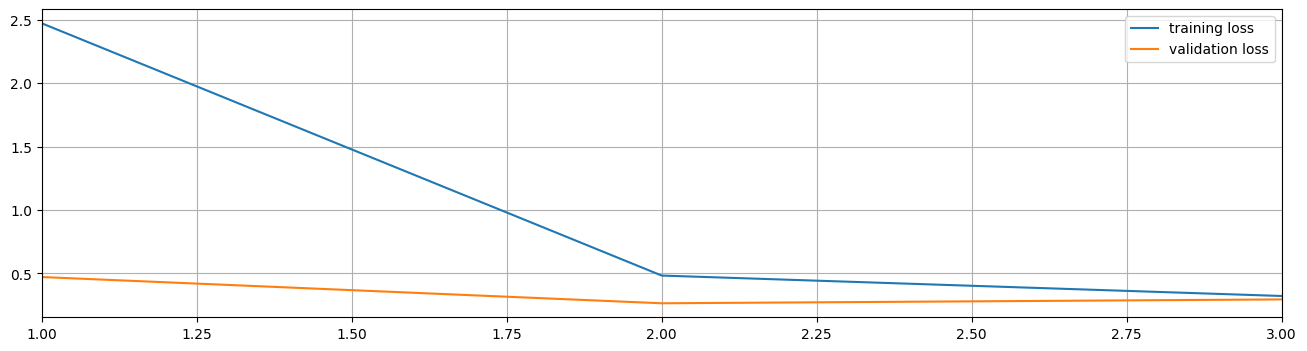

In [59]:
%%time
bs = 64
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=3)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=3)

resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, num_of_classes)
freeze_to(resnet50, -1, True)

resnet50 = resnet50.cuda()

fit(resnet50, tr_dl, val_dl, epochs=3)

# Model by Vishal

# Model by Ayo